In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque, OrderedDict
import torch
import time
import torch.nn.functional as F
import copy
from torch import nn
import torch.optim as optim
from scipy import signal
from torchviz import make_dot
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def weighted_mse_loss(pred, target, weights):
    return torch.mean(weights * (pred - target) ** 2)

def np_to_torch(a):
    """
    Convert numpy array into a pytorch tensor and send to device
    """
    return torch.from_numpy(a).float().to(device)


def scale_weights(model, scale):
    """
    Multiply all model weights by a given multiplier.
    """
    for param in model.parameters():
        param.data.copy_(param.data * scale)


class ActorNetwork(nn.Module):
    """
    An actor network which simultaneously prescribes an action to take as a fucntion of state.
    """
    
    def __init__(self, state_size, action_size, seed, hidden_sizes_list):
        """Initialize parameters and build model.
        
        Inputs:
            state_size (int): Dimension of each state.
            action_size (int): Dimension of each action.
            seed (int): Random seed.
            hidden_sizes_list (list): The sizes of hidden layers in the network.
        """
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        model = OrderedDict([
            ['fc_1', nn.Linear(state_size, hidden_sizes_list[0])],
            ['relu_1', nn.ReLU()]
        ])
        for i in range(1, len(hidden_sizes_list)):
            model['fc_{}'.format(i + 1)] = nn.Linear(hidden_sizes_list[i - 1], hidden_sizes_list[i])
            model['relu_{}'.format(i + 1)] = nn.ReLU()
        model['fc_output'] = nn.Linear(hidden_sizes_list[-1], action_size)
        self.model = nn.Sequential(model)
        self.tanh = nn.Tanh()

    def forward(self, state):
        """ Forward propagation through the network."""
        return self.tanh(self.model(state))


class CriticNetwork(nn.Module):
    """
    A critic network which predicts the action value for a state.
    Action is inserted as an input to the last hidden layer.
    """
    
    def __init__(self, state_size, action_size, seed, hidden_sizes_list):
        """Initialize parameters and build model.
        
        Inputs:
            state_size (int): Dimension of each state.
            action_size (int): Dimension of each action.
            seed (int): Random seed.
            hidden_sizes_list (list): The sizes of hidden layers in the network.
        """
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        model_first_part = OrderedDict([
            ['fc_1', nn.Linear(2 * state_size, hidden_sizes_list[0])],
            ['relu_1', nn.ReLU()]
        ])
        self.model_first_part = nn.Sequential(model_first_part)
        model_second_part = OrderedDict()
        for i in range(1, len(hidden_sizes_list)):
            model_second_part['fc_{}'.format(i + 1)] = nn.Linear(hidden_sizes_list[i - 1] + 2 * action_size * (i==1), hidden_sizes_list[i])
            model_second_part['relu_{}'.format(i + 1)] = nn.ReLU()
        self.model_second_part = nn.Sequential(model_second_part)
        self.output_layer = nn.Linear(hidden_sizes_list[-1], 1)

    def forward(self, state, action):
        """ Forward propagation through the network."""
        x = self.model_first_part(state)
        x = torch.cat([x, action], 1)
        x = self.model_second_part(x)
        x = self.output_layer(x)
        return x

In [3]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, use_prioritized_replay):
        """Initialize a ReplayBuffer object.

        Inputs:
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            use_prioritized_replay (boolean)
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.weights = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.use_prioritized_replay = use_prioritized_replay
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory.
        
        Inputs:
            state: Current state
            action: Action taken in the current state.
            reward: Reward received at the current step.
            next_state: A state into which the transition occurs.
            done: An indicator of the transition learding into a terminal state.
        """
        es = [self.experience(states, actions, rewards, next_states, dones)]
        for e in es:
            self.memory.append(e)
            if self.use_prioritized_replay:
                self.weights.append(10)
            else:
                self.weights.append(1)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        indices = random.choices(range(len(self.memory)), weights=self.weights, k=self.batch_size)
        experiences = [self.memory[i] for i in indices]
        weights = [self.weights[i] for i in indices]
        
        states = {}
        actions = {}
        rewards = {}
        next_states = {}
        dones = {}
        for i in range(2):
            states[i] = torch.from_numpy(np.vstack([e.state[i,:] for e in experiences if e is not None])).float().to(device)
            actions[i] = torch.from_numpy(np.vstack([e.action[i,:] for e in experiences if e is not None])).float().to(device)
            rewards[i] = torch.from_numpy(np.vstack([e.reward[i] for e in experiences if e is not None])).float().to(device)
            next_states[i] = torch.from_numpy(np.vstack([e.next_state[i,:] for e in experiences if e is not None])).float().to(device)
            dones[i] = torch.from_numpy(np.vstack([e.done[i] for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones, indices, weights)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    def update_weights(self, indices, weights):
        assert len(indices) == len(weights)
        for i,w in zip(indices, weights):
            self.weights[i] = w

In [4]:
class OUProcess():
    """
    Orstein-Uhlenbeck process.
    """
    
    def __init__(self, theta, sigma, dims, mu=0.0):
        self.theta = theta
        self.sigma = sigma
        self.dims = dims
        self.mu = mu
        self.values = np.ones(dims) * mu
        
    def sample(self):
        self.values += self.theta * (self.mu - self.values) + self.sigma * np.random.normal(size=self.dims)
        return self.values
    
    def reset(self):
        self.values = np.ones(self.dims) * self.mu

class Agent():
    """
    An RL agent which can interact with an environment and learn from replayed experiences.
    Uses an actor-critic method for continuous actions (DDPG).
    """
    
    def __init__(self, num_instances, state_size, action_size, seed, actor_hidden_sizes_list, critic_hidden_sizes_list,
                 num_iters_learn=1, update_every=4, use_prioritized_replay=True, batch_size=128, gamma=0.99, buffer_size=int(1e6),
                 update_target_network_every=1, actor_lr0=1e-4, critic_lr0=1e-3,
                 noise_theta=0.15, noise_sigma=0.2, noise_sigma_decay=1.0, weight_decay=0.0,
                 actor_reg_loss_weight=0.0, random_seed=0):
        """ Initialize an Agent object.
        
        Inputs:
            num_instances (int): Number of actors running in parallel.
            state_size (int): The dimensionality of the state space.
            action_size (int): Number of possible actions an agent can take.
            seed (int): Randomization seed.
            actor_hidden_sizes_list (list): The sizes of hidden layers in the actor network.
            critic_hidden_sizes_list (list): The sizes of hidden layers in the critic network.
            num_iters_learn (int, optional): Number of iterations to take at each step towards the targets.
            update_every (int, optional): How often the main networks are updated (default 1).
            batch_size (int, optional): Batch size for each upate (default 64).
            gamma (float, optional): Temporal discount coefficient (default 0.99).
            buffer_size (int, optional): Maximum capacity of the replay buffer (default 1e6).
            update_target_network_every (int, optional): How often to update the target network (default 1).
            actor_lr0 (float, optional): Initial learning rate for the actor (default 1e-4).
            critic_lr0 (float, optional): Initial learning rate for the critic (default 1e-3).
            noise_theta (float): Parameter of Ornstein-Uhlenbeck noise process.
            noise_sigma (float): Parameter of Ornstein-Uhlenbeck noise process.
            noise_sigma_decay (float): Multiplier for noise_sigma (per episode).
            weight_decay (float): Weight decay parameter for both actor and critic networks.
            actor_reg_loss_weight (float): Weight placed on L2 norm of actions.
            random_seed (int): Seed for pseudo-random numbers.
        """
        self.num_instances = num_instances
        self.action_size = action_size
        self.state_size = state_size
        self.seed = seed
        self.num_iters_learn = num_iters_learn
        self.update_every = update_every
        self.use_prioritized_replay = use_prioritized_replay
        self.batch_size = batch_size
        self.gamma = gamma
        self.actor_lr0 = actor_lr0
        self.critic_lr0 = critic_lr0
        self.update_target_network_every = update_target_network_every
        self.actor_network_main = ActorNetwork(state_size, action_size, seed, actor_hidden_sizes_list).to(device)
        self.actor_network_target = ActorNetwork(state_size, action_size, seed, actor_hidden_sizes_list).to(device)
        self.soft_update(self.actor_network_main, self.actor_network_target, tau=1.0)
        self.actor_network_target.eval()
        
        self.critic_network_main = CriticNetwork(state_size, action_size, seed, critic_hidden_sizes_list).to(device)
        self.critic_network_target = CriticNetwork(state_size, action_size, seed, critic_hidden_sizes_list).to(device)
        self.soft_update(self.critic_network_main, self.critic_network_target, tau=1.0)
        self.critic_network_target.eval()
        
        self.actor_optimizer = optim.Adam(self.actor_network_main.parameters(), lr=actor_lr0, weight_decay=weight_decay)
        self.critic_optimizer = optim.Adam(self.critic_network_main.parameters(), lr=critic_lr0, weight_decay=weight_decay)
        self.actor_reg_loss_weight = actor_reg_loss_weight
        self.actor_reg_loss_fn = lambda x: F.mse_loss(x, torch.zeros_like(x))
        

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed, use_prioritized_replay)
        # Initialize time step (for updating every "update_every" steps)
        self.t_step = 0
        # Initialize OU noise
        self.noise = OUProcess(theta=noise_theta, sigma=noise_sigma, dims=(num_instances, action_size))
        self.noise_sigma_decay = noise_sigma_decay

    def step(self, states, actions, rewards, next_states, dones, num_agent):       
        """
        Process a vector of state changes.
        Periodically learn (update network) if enough experiences are available in the replay buffer.
        
        Inputs:
            states: Current state
            actions: Action taken in the current state.
            rewards: Reward received at the current step.
            next_states: A state into which the transition occurs.
            dones: An indicator of the transition learding into a terminal state.
        """
        
        # Save experience in replay memory
        self.memory.add(states, actions, rewards, next_states, dones)
        self.t_step += 1
        
        if self.t_step % self.update_every == 0: # Learn every "update_every" time steps.
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma, num_agent)
        
               
    def act(self, states):
        """Returns actions for given states as per current policy.
        
        Inputs:
            states (array_like): current states
            eps (float): epsilon, for epsilon-greedy action selection
        """
        states = torch.from_numpy(states).float().to(device)
        self.actor_network_main.eval()
        with torch.no_grad():
            actions = self.actor_network_main(states).cpu().data.numpy()
        self.actor_network_main.train()
        return np.tanh(np.arctanh(actions) + self.noise.sample())
#         return np.clip(actions + self.noise.sample(), -1, 1)

                
    def learn(self, experiences, gamma, num_agent):
        """Update value parameters using given batch of experience tuples.

        Inputs:
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, indices, weights = experiences
        probs = np.array(weights) / sum(weights)
        is_weights = np.power(1.0 / (len(self.memory) * probs), 0.5)
        is_weights = is_weights / max(is_weights)
        
        for _ in range(self.num_iters_learn):
            # get targets for the critic network
            with torch.no_grad():
                actor_target_next_actions = self.actor_network_target(next_states[num_agent])
                other_actor_target_next_actions = self.other_agent.actor_network_target(next_states[1-num_agent])
                both_agents_next_actions = torch.cat((actor_target_next_actions, other_actor_target_next_actions), 1)
                both_agents_next_states = torch.cat((next_states[num_agent], next_states[1-num_agent]), 1)
                Q_targets_next = self.critic_network_target(both_agents_next_states, both_agents_next_actions)
                critic_targets = (rewards[num_agent] + gamma * Q_targets_next * (1 - dones[num_agent])).squeeze()
            
            # update critic
            both_agents_states = torch.cat((states[num_agent], states[1-num_agent]), 1)
            both_agents_actions = torch.cat((actions[num_agent], actions[1-num_agent]), 1)
            critic_predictions = self.critic_network_main(both_agents_states, both_agents_actions).squeeze()
            critic_errors = (critic_predictions - critic_targets).squeeze()
            critic_loss = weighted_mse_loss(critic_predictions, critic_targets, np_to_torch(is_weights).float())
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            # update actor
            actor_proposed_actions = self.actor_network_main(states[num_agent])
            with torch.no_grad():
                other_agent_actor_proposed_actions = self.other_agent.actor_network_target(states[1-num_agent])
            actor_objective = (self.critic_network_main(both_agents_states, torch.cat((actor_proposed_actions, other_agent_actor_proposed_actions), 1))\
                               * np_to_torch(is_weights)).mean()
            actor_loss = -actor_objective + self.actor_reg_loss_weight * self.actor_reg_loss_fn(actor_proposed_actions)
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
        if self.use_prioritized_replay:
            self.memory.update_weights(indices, np.power(critic_errors.abs().data.numpy(), 1.5))
        
        if self.t_step % self.update_target_network_every == 0:
            self.soft_update(self.critic_network_main, self.critic_network_target, 1e-3)
            self.soft_update(self.actor_network_main, self.actor_network_target, 1e-3)

    def soft_update(self, main_model, target_model, tau=3e-2):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Inputs:
            main_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), main_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [6]:
env = UnityEnvironment(file_name='Tennis.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
num_agents = states.shape[0]
state_size = states.shape[1]


def learn_maddpg(env, agents, scores, n_episodes=3000, num_episodes_random_actions = 300, max_t=1000, save_every=100,
        print_every = 100, lr_decay_episode=0.9986, actor_min_lr = 1e-7, critic_min_lr = 3e-7):
    """Mutli-Agent Deep Deterministic Policy Gradient

    Params
    ======
        env: An environment
        agents: A list of RL agents
        scores (list): A list where the scores will be saved.
        n_episodes (int): maximum number of training episodes
        num_episodes_random_actions (int): How long to do pure exploration
        max_t (int): maximum number of timesteps per episode
        save_every (int): How often to save the checkpoints
        print_every (int): How often to print progress
        lr_decay_episode (float): Learning rate decay multiplier (per episode)
        actor_min_lr (float): Minimum actor learning rate (capped at the bottom at this value)
        critic_min_lr (float): Minimum critic learning rate (capped at the bottom at this value)
    """
    num_players = len(agents)
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_window_2actors = deque(maxlen=100)  # last 100 scores
    hundred_episodes_start_time = time.time()
    solved = False
    for i_episode in range(1, n_episodes+1):
        for agent in agents:
            for param_group in agent.actor_optimizer.param_groups:
                # adjust actor learning rate
                param_group['lr'] = max(agent.actor_lr0 * lr_decay_episode**i_episode, actor_min_lr)
                actor_lr = param_group['lr']
            for param_group in agent.critic_optimizer.param_groups:
                # adjust critic learning rate
                param_group['lr'] = max(agent.critic_lr0 * lr_decay_episode**i_episode, critic_min_lr)
                critic_lr = param_group['lr']
            # reduce action noise variance
            if i_episode > num_episodes_random_actions:
                agent.noise.reset()
                agent.noise.sigma *= agent.noise_sigma_decay
        episode_start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations            # get the current state
        scores_this_episode = np.zeros(num_players)
        for t in range(max_t):
            if i_episode > num_episodes_random_actions:
                actions = np.empty((num_players, action_size))
                for i, agent in enumerate(agents):
                    actions[i,:] = agent.act(states[i:(i+1),:])
            else:
                actions = np.random.uniform(-1, 1, size=(num_players, action_size))
            env_info = env.step(actions)[env.brain_names[0]]        # send the actions to the environment
            next_states = env_info.vector_observations   # get the next states
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            scores_this_episode += rewards                                # update the score
            for i, agent in enumerate(agents):
                agent.step(states, actions, rewards, next_states, dones, num_agent=i)
            states = next_states                             # roll over the state to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break
        scores_window.append(np.max(scores_this_episode))       # save most recent score
        scores_window_2actors.append(scores_this_episode)
        scores.append(np.max(scores_this_episode))              # save most recent score
        episode_end_time = time.time()
        if i_episode % print_every == 0:
            print('Actions: {}'.format(actions))
            print('Current noise:{:.2f}'.format(agents[0].noise.sigma))
            print('Current actor LR:{:.6f}'.format(actor_lr))
            print('Current critic LR:{:.6f}'.format(critic_lr))
            print('Average score per actor:{}'.format(np.array(scores_window_2actors).mean(0)))
            print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}, episode took {:.2f} seconds'.format(i_episode,
                np.max(scores_this_episode), np.mean(scores_window), episode_end_time - episode_start_time))
        if i_episode % save_every == 0:
            hundred_episodes_end_time = time.time()
            torch.save(agents[0].actor_network_main.state_dict(), 'checkpoints/checkpoint_actor_{}.pth'.format(i_episode))
            torch.save(agents[0].critic_network_main.state_dict(), 'checkpoints/checkpoint_critic_{}.pth'.format(i_episode))
            hundred_episodes_start_time = time.time()
        if (np.mean(scores_window) >= 0.5) & ~solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,\
                np.mean(scores_window)))
            torch.save(agents[0].actor_network_main.state_dict(), 'checkpoints/final_checkpoint_actor.pth')
            torch.save(agents[0].critic_network_main.state_dict(), 'checkpoints/final_checkpoint_critic.pth')
            break


agents = []
for _ in range(num_agents):
    agents.append(Agent(num_instances=1,
                  state_size=state_size,
                  action_size=action_size,
                  seed=0,
                  actor_hidden_sizes_list=[64, 64],
                  critic_hidden_sizes_list=[64, 64],
                  gamma=0.99,
                  num_iters_learn=1,
                  actor_lr0=1e-3,
                  critic_lr0=3e-3,
                  weight_decay=0e-6,
                  actor_reg_loss_weight=0.0025,
                  update_every=1,
                  noise_sigma=0.3,
                  noise_sigma_decay=0.997,
                  buffer_size=int(1e6),
                  batch_size=128,
                  use_prioritized_replay=True))
agents[0].other_agent = agents[1]
agents[1].other_agent = agents[0]
            
scores = []
learn_maddpg(env, agents, scores)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Actions: [[-0.10820136  0.24186577]
 [ 0.95989601  0.85204035]]
Current noise:0.30
Current actor LR:0.000869
Current critic LR:0.002608
Average score per actor:[0.0046 0.0054]
Episode 100	Current Score: 0.09	Average Score: 0.02, episode took 0.47 seconds
Actions: [[ 0.0576414  -0.50149076]
 [ 0.41481171  0.02698048]]
Current noise:0.30
Current actor LR:0.000756
Current critic LR:0.002267
Average score per actor:[0.0101 0.0008]
Episode 200	Current Score: 0.00	Average Score: 0.02, episode took 0.23 seconds
Actions: [[ 0.02851862 -0.85279162]
 [-0.64108417  0.26303867]]
Current noise:0.30
Current actor LR:0.000657
Current critic LR:0.001971
Average score per actor:[0.0047 0.0043]
Episode 300	Current Score: 0.10	Average Score: 0.02, episode took 0.52 seconds


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in arctanh


Actions: [[0.99904672 0.33386424]
 [0.05576124 0.52024812]]
Current noise:0.22
Current actor LR:0.000571
Current critic LR:0.001713
Average score per actor:[-0.0035  0.0135]
Episode 400	Current Score: 0.09	Average Score: 0.02, episode took 0.55 seconds
Actions: [[ 0.59705752  0.62849489]
 [-0.04818483  0.2755071 ]]
Current noise:0.16
Current actor LR:0.000496
Current critic LR:0.001489
Average score per actor:[0.0091 0.0129]
Episode 500	Current Score: 0.00	Average Score: 0.03, episode took 0.25 seconds
Actions: [[ 0.30117287  0.04586172]
 [ 0.31339432 -0.37591949]]
Current noise:0.12
Current actor LR:0.000431
Current critic LR:0.001294
Average score per actor:[0.0055 0.0024]
Episode 600	Current Score: 0.00	Average Score: 0.02, episode took 0.26 seconds
Actions: [[-0.03146085 -0.53021133]
 [ 0.13602211  0.09467535]]
Current noise:0.09
Current actor LR:0.000375
Current critic LR:0.001125
Average score per actor:[0.0124 0.0016]
Episode 700	Current Score: 0.00	Average Score: 0.02, episode 

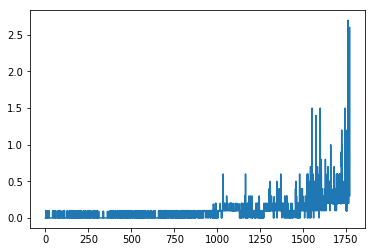

In [10]:
plt.plot(scores)

In [11]:
env.close()

# Visualize trained agent

In [5]:
env = UnityEnvironment(file_name='Tennis.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
num_agents = states.shape[0]
state_size = states.shape[1]

actor_checkpoint = torch.load('checkpoints/final_checkpoint_actor.pth')
agents = []
for _ in range(num_agents):
    agents.append(Agent(num_instances=1,
                  state_size=state_size,
                  action_size=action_size,
                  seed=0,
                  actor_hidden_sizes_list=[64, 64],
                  critic_hidden_sizes_list=[64, 64],
                  gamma=0.99,
                  num_iters_learn=1,
                  actor_lr0=0.0,
                  critic_lr0=0.0,
                  weight_decay=0e-6,
                  actor_reg_loss_weight=0.0025,
                  update_every=1,
                  noise_sigma=0.0,
                  noise_sigma_decay=0.0,
                  buffer_size=int(1e6),
                  batch_size=128,
                  use_prioritized_replay=True))
    agents[-1].actor_network_main.load_state_dict(actor_checkpoint)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [6]:
states = env_info.vector_observations            # get the current state
for t in range(1000):
    actions = np.empty((num_agents, action_size))
    for i, agent in enumerate(agents):
        actions[i,:] = agent.act(states[i:(i+1),:])
    env_info = env.step(actions)[env.brain_names[0]]        # send the actions to the environment
    next_states = env_info.vector_observations   # get the next states
    rewards = env_info.rewards                   # get the reward
    dones = env_info.local_done                  # see if episode has finished
    states = next_states       